# SageMaker Demo: Employee Attrition Prediction Using Debugger

This notebook demonstrates how to use Amazon SageMaker's Debugger for employee attrition binary classification.

In [74]:
# Step 1: Setup
import sagemaker
from sagemaker import get_execution_role
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split 

sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name

# S3 bucket for storing data
bucket = 'sagemaker-ml-28573'


# Load the dataset
file_path = 'Employee.csv'  # Replace with your actual file path in S3 if needed
employee_df = pd.read_csv(file_path)
employee_df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [75]:
# Step 2: Data Preparation
# Convert categorical columns to numeric
employee_df['Education'] = employee_df['Education'].astype('category').cat.codes
employee_df['City'] = employee_df['City'].astype('category').cat.codes
employee_df['Gender'] = employee_df['Gender'].astype('category').cat.codes
employee_df['EverBenched'] = employee_df['EverBenched'].map({'Yes': 1, 'No': 0})

# Drop rows with NaN values in the target column
employee_df.dropna(subset=['LeaveOrNot'])

# Convert target column to numeric if needed
employee_df['LeaveOrNot'] = employee_df['LeaveOrNot'].astype(int)

# Ensure no missing values in feature columns
employee_df = employee_df.dropna()

# Verify all columns are numeric
print(employee_df.dtypes)

# Define features and target
feature_columns = [
    'Education', 'JoiningYear', 'City', 'PaymentTier', 'Age',
    'Gender', 'EverBenched', 'ExperienceInCurrentDomain'
]
target_column = 'LeaveOrNot'

employee_df = employee_df[[target_column] + feature_columns]


train_df, test_df = train_test_split(employee_df, test_size=0.2, random_state=42)

# Display the transformed dataset
employee_df.head()

Education                     int8
JoiningYear                  int64
City                          int8
PaymentTier                  int64
Age                          int64
Gender                        int8
EverBenched                  int64
ExperienceInCurrentDomain    int64
LeaveOrNot                   int64
dtype: object


,LeaveOrNot,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,0,0,2017,0,3,34,1,0,0
1,1,0,2013,2,1,28,0,0,3
2,0,0,2014,1,3,38,0,0,2
3,1,1,2016,0,3,27,1,0,5
4,1,1,2017,2,3,24,1,1,2


## Preparing Training Data Paths

In [76]:
# Initialize S3 client
s3 = boto3.client('s3')

# Define your S3 bucket and prefix
bucket = 'sagemaker-ml-28573'
prefix = 'input-data'

# Save the data locally first
train_file = 'train.csv'
validation_file = 'validation.csv'
train_df.to_csv(train_file, index=False)
test_df.to_csv(validation_file, index=False)

# Upload the data to S3
s3.upload_file(train_file, bucket, f'{prefix}/train/{train_file}')
s3.upload_file(validation_file, bucket, f'{prefix}/validation/{validation_file}')

print(f"Training data uploaded to s3://{bucket}/{prefix}/train/{train_file}")
print(f"Validation data uploaded to s3://{bucket}/{prefix}/validation/{validation_file}")


Training data uploaded to s3://sagemaker-ml-28573/input-data/train/train.csv
Validation data uploaded to s3://sagemaker-ml-28573/input-data/validation/validation.csv


## Prepare Training with Bad Hyperparameters

In [77]:
import sagemaker
import boto3
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

# Initialize hyperparameters
hyperparameters = {
        "max_depth":"15", # very high depth
        "eta":"0.2",
        "gamma":"80", # change value here
        "min_child_weight":"6",
        "subsample":"0.95", # too high
        "objective":"reg:squarederror",
        "num_round":"60"}

# Set an output path where the trained model will be saved
bucket = 'sagemaker-ml-28573'
prefix = 'debugger'
output_path = f's3://{bucket}/{prefix}/output'

# Retrieve the XGBoost image URI
region = boto3.Session().region_name  # Automatically get the region
xgboost_container = image_uris.retrieve("xgboost", region, "1.7-1")

# Construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.xlarge', 
                                          volume_size=5,  # 5 GB 
                                          output_path=output_path)

# Define the data type and paths to the training and validation datasets
content_type = "csv"
train_input = TrainingInput(f"s3://{bucket}/input-data/train/", content_type=content_type)
validation_input = TrainingInput(f"s3://{bucket}/input-data/validation/", content_type=content_type)

# Execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-03-09-49-39-745


2024-09-03 09:49:41 Starting - Starting the training job...
2024-09-03 09:49:55 Starting - Preparing the instances for training...
2024-09-03 09:50:26 Downloading - Downloading input data...
2024-09-03 09:50:51 Downloading - Downloading the training image.....[2024-09-03 09:51:54.787 ip-10-2-123-204.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-09-03 09:51:54.809 ip-10-2-123-204.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-09-03:09:51:55:INFO] Imported framework sagemaker_xgboost_container.training
[2024-09-03:09:51:55:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-09-03:09:51:55:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-03:09:51:55:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-09-03:09:51:55:INFO] Determined 0 GPU(s) available on the instance.
[2024-09-03:09:51:55:INFO] Determined delimiter of CSV input is ','
[2024-09-03:0

## Deploy Model

In [78]:
# Deploy model

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-09-03-09-52-26-691
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-09-03-09-52-26-691
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-09-03-09-52-26-691


------!

In [79]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up the predictor
predictor.content_type = "text/csv"
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()


In [80]:
# Define a function to make predictions
def predict(data, predictor, rows=500):
    # Split the test data into mini-batches of rows
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    
    # Initialize an empty list for predictions
    predictions = []
    
    # Iterate through the mini-batches and make predictions
    for array in split_array:
        # Make a prediction for the mini-batch
        pred = predictor.predict(array)
        
        # Assuming pred is a dictionary, extract the prediction values
        if isinstance(pred, dict):
            pred_values = pred.get("predictions", [])
            
            # If predictions are a list of dictionaries, extract the values
            if isinstance(pred_values, list):
                for value in pred_values:
                    if isinstance(value, dict):
                        # Assuming each dictionary has a key that holds the actual prediction
                        predictions.append(value.get("predicted_label", value.get("score", 0.0)))
                    else:
                        predictions.append(value)
        else:
            predictions.append(pred)

    # Convert the list of predictions directly to a NumPy array
    return np.array(predictions, dtype=float)

# Load your test data into a NumPy array (assuming your test data is a Pandas DataFrame)
test_df_np = test_df.to_numpy()

# Separate the target variable (assumed to be in the first column) from the features
actual = test_df_np[:, 0]   # First column is the target
features = test_df_np[:, 1:]  # Remaining columns are the features

# Make predictions on the features only
predictions = predict(features, predictor)

# Since this is binary classification, round the predictions
predictions_rounded = np.round(predictions)


In [100]:
# Evaluate the model
conf_matrix = confusion_matrix(actual, predictions_rounded)
class_report = classification_report(actual, predictions_rounded)
accuracy = accuracy_score(actual, predictions_rounded)

# Print the evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
 [[610   0]
 [240  81]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84       610
           1       1.00      0.25      0.40       321

    accuracy                           0.74       931
   macro avg       0.86      0.63      0.62       931
weighted avg       0.81      0.74      0.69       931


Accuracy Score: 0.7422126745435016


In [ ]:
!pip install seaborn

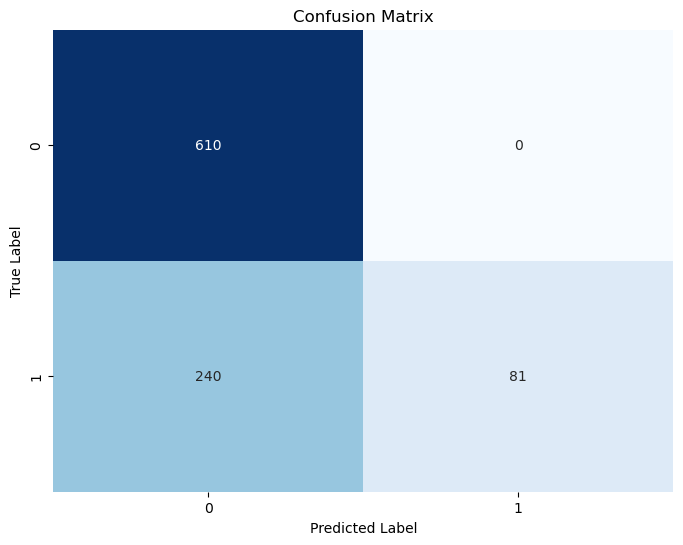

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Assume predictions_rounded and actual are already available
# actual = test_df_np[:, 0]  # Assuming the first column is the actual target

# Confusion Matrix
conf_matrix = confusion_matrix(actual, predictions_rounded)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [84]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, Rule, rule_configs


rules = [
    Rule.sagemaker(rule_configs.overtraining()),  # Detects when the model is overtraining (overfitting)
    Rule.sagemaker(rule_configs.loss_not_decreasing()),  # Detects when the loss stops decreasing
]

# Define Debugger Hook Configuration

debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/{prefix}/debugger-output',
    collection_configs=[
        CollectionConfig(name="metrics", parameters={"save_interval": "5"}),  # Capture metrics every 5 steps
    ]
)


xgboost_estimator_debug = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size=5,
    output_path=output_path,
    debugger_hook_config=debugger_hook_config,
    rules=rules  # Attach the rules
)

# Train the model
xgboost_estimator_debug.fit({'train': train_input, 'validation': validation_input})


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-03-09-55-59-739


2024-09-03 09:56:00 Starting - Starting the training job...
2024-09-03 09:56:27 Starting - Preparing the instances for trainingOvertraining: InProgress
LossNotDecreasing: InProgress
...
2024-09-03 09:56:58 Downloading - Downloading input data...
2024-09-03 09:57:20 Downloading - Downloading the training image.....[2024-09-03 09:58:17.020 ip-10-2-201-49.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-09-03 09:58:17.042 ip-10-2-201-49.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-09-03:09:58:17:INFO] Imported framework sagemaker_xgboost_container.training
[2024-09-03:09:58:17:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-09-03:09:58:17:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-03:09:58:17:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-09-03:09:58:17:INFO] Determined 0 GPU(s) available on the instance.
[2024-09-03:09:58:17:INFO] D

In [85]:
import time

# Monitor the training job and the rule evaluations
for _ in range(360):  # Adjust the range based on your expected training duration
    job_name = xgboost_estimator_debug.latest_training_job.name
    client = xgboost_estimator_debug.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    
    print(f"Training job status: {training_job_status}, Rule Evaluation Status: {rule_evaluation_status}")
    
    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break
    
    time.sleep(10)  # Poll every 10 seconds

# Print the final rule evaluation status
rule_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
for rule in rule_summary:
    print(f"Rule: {rule['RuleConfigurationName']}, Status: {rule['RuleEvaluationStatus']}")


Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProg

In [ ]:
!pip install smdebug

In [86]:
from smdebug.trials import create_trial

# Load the data from the S3 path where Debugger saved it
s3_output_path = xgboost_estimator_debug.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)


[2024-09-03 10:01:28.895 default:604 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ml-28573/debugger/debugger-output/sagemaker-xgboost-2024-09-03-09-55-59-739/debug-output


In [87]:
for tensor_name in trial.tensor_names():
    print(tensor_name)


train-rmse
validation-rmse


In [88]:
# Retrieve the train and validation RMSE tensors
train_rmse_tensor = trial.tensor('train-rmse')
validation_rmse_tensor = trial.tensor('validation-rmse')

# Get the steps (epochs) and values for each tensor
train_rmse_steps = train_rmse_tensor.steps()
train_rmse_values = np.array([train_rmse_tensor.value(step) for step in train_rmse_steps])

validation_rmse_steps = validation_rmse_tensor.steps()
validation_rmse_values = np.array([validation_rmse_tensor.value(step) for step in validation_rmse_steps])


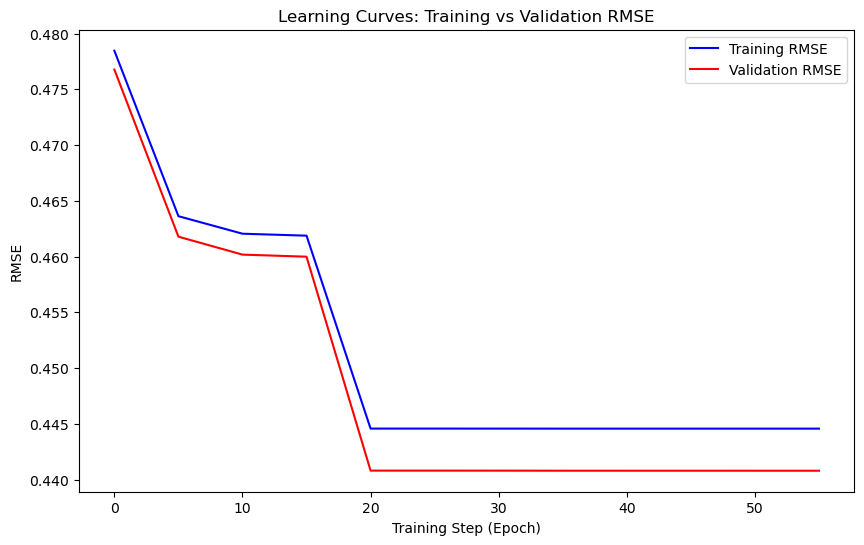

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training RMSE
plt.plot(train_rmse_steps, train_rmse_values, label='Training RMSE', color='blue')

# Plot validation RMSE
plt.plot(validation_rmse_steps, validation_rmse_values, label='Validation RMSE', color='red')

# Add labels and title
plt.xlabel('Training Step (Epoch)')
plt.ylabel('RMSE')
plt.title('Learning Curves: Training vs Validation RMSE')
plt.legend()

# Show the plot
plt.show()


In [90]:
# Print the contents to verify
print("Train RMSE Steps:", train_rmse_steps)
print("Train RMSE Values:", train_rmse_values)

print("Validation RMSE Steps:", validation_rmse_steps)
print("Validation RMSE Values:", validation_rmse_values)


Train RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Train RMSE Values: [[0.47846699]
 [0.46362741]
 [0.4620554 ]
 [0.4618795 ]
 [0.44457662]
 [0.44457671]
 [0.44457516]
 [0.44457311]
 [0.44457307]
 [0.44457307]
 [0.44457321]
 [0.44457324]]
Validation RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Validation RMSE Values: [[0.47677623]
 [0.46178845]
 [0.46018003]
 [0.45999307]
 [0.44080658]
 [0.44080672]
 [0.44080406]
 [0.44079902]
 [0.44079836]
 [0.44079861]
 [0.44079773]
 [0.44079768]]


In [91]:
# Initialize hyperparameters
hyperparameters = {
        "max_depth":"5", # lower depth
        "eta":"0.2",
        "gamma":"5", # change value here
        "min_child_weight":"6",
        "subsample":"0.5", # lower value
        "objective":"reg:squarederror",
        "num_round":"60"}

In [92]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, Rule, rule_configs


rules = [
    Rule.sagemaker(rule_configs.overtraining()),  # Detects when the model is overtraining (overfitting)
    Rule.sagemaker(rule_configs.loss_not_decreasing()),  # Detects when the loss stops decreasing
]

# Define Debugger Hook Configuration

debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/{prefix}/debugger-output',
    collection_configs=[
        CollectionConfig(name="metrics", parameters={"save_interval": "5"}),  # Capture metrics every 5 steps
    ]
)


xgboost_estimator_debug = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size=5,
    output_path=output_path,
    debugger_hook_config=debugger_hook_config,
    rules=rules  # Attach the rules
)

# Train the model
xgboost_estimator_debug.fit({'train': train_input, 'validation': validation_input})


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-03-10-01-32-452


2024-09-03 10:01:34 Starting - Starting the training job...
2024-09-03 10:01:58 Starting - Preparing the instances for trainingOvertraining: InProgress
LossNotDecreasing: InProgress
...
2024-09-03 10:02:20 Downloading - Downloading input data...
2024-09-03 10:02:58 Downloading - Downloading the training image...
2024-09-03 10:03:36 Training - Training image download completed. Training in progress...[2024-09-03 10:03:43.734 ip-10-0-135-246.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-09-03 10:03:43.759 ip-10-0-135-246.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-09-03:10:03:44:INFO] Imported framework sagemaker_xgboost_container.training
[2024-09-03:10:03:44:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-09-03:10:03:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-03:10:03:44:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-09-03:

In [93]:
import time

# Monitor the training job and the rule evaluations
for _ in range(360):  # Adjust the range based on your expected training duration
    job_name = xgboost_estimator_debug.latest_training_job.name
    client = xgboost_estimator_debug.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    
    print(f"Training job status: {training_job_status}, Rule Evaluation Status: {rule_evaluation_status}")
    
    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break
    
    time.sleep(10)  # Poll every 10 seconds

# Print the final rule evaluation status
rule_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
for rule in rule_summary:
    print(f"Rule: {rule['RuleConfigurationName']}, Status: {rule['RuleEvaluationStatus']}")


Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: NoIssu

In [30]:
!pip install smdebug

In [94]:
from smdebug.trials import create_trial

# Load the data from the S3 path where Debugger saved it
s3_output_path = xgboost_estimator_debug.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)


[2024-09-03 10:06:41.053 default:604 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ml-28573/debugger/debugger-output/sagemaker-xgboost-2024-09-03-10-01-32-452/debug-output


In [95]:
for tensor_name in trial.tensor_names():
    print(tensor_name)


train-rmse
validation-rmse


In [96]:
# Retrieve the train and validation RMSE tensors
train_rmse_tensor = trial.tensor('train-rmse')
validation_rmse_tensor = trial.tensor('validation-rmse')

# Get the steps (epochs) and values for each tensor
train_rmse_steps = train_rmse_tensor.steps()
train_rmse_values = np.array([train_rmse_tensor.value(step) for step in train_rmse_steps])

validation_rmse_steps = validation_rmse_tensor.steps()
validation_rmse_values = np.array([validation_rmse_tensor.value(step) for step in validation_rmse_steps])


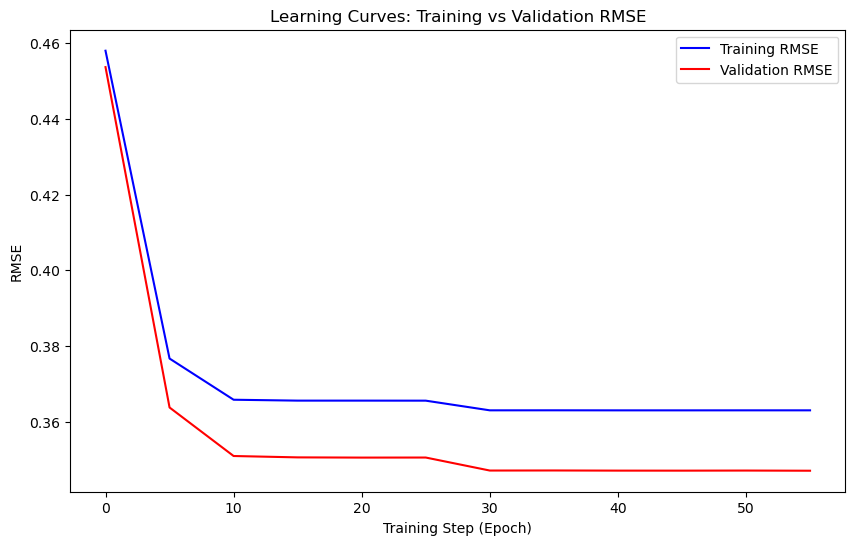

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training RMSE
plt.plot(train_rmse_steps, train_rmse_values, label='Training RMSE', color='blue')

# Plot validation RMSE
plt.plot(validation_rmse_steps, validation_rmse_values, label='Validation RMSE', color='red')

# Add labels and title
plt.xlabel('Training Step (Epoch)')
plt.ylabel('RMSE')
plt.title('Learning Curves: Training vs Validation RMSE')
plt.legend()

# Show the plot
plt.show()


In [98]:
# Print the contents to verify
print("Train RMSE Steps:", train_rmse_steps)
print("Train RMSE Values:", train_rmse_values)

print("Validation RMSE Steps:", validation_rmse_steps)
print("Validation RMSE Values:", validation_rmse_values)


Train RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Train RMSE Values: [[0.45803475]
 [0.37670372]
 [0.36582111]
 [0.36558543]
 [0.3655869 ]
 [0.36557636]
 [0.36302102]
 [0.36302919]
 [0.36301551]
 [0.36301454]
 [0.36302018]
 [0.36302051]]
Validation RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Validation RMSE Values: [[0.4537078 ]
 [0.36377222]
 [0.35095253]
 [0.35059081]
 [0.35053421]
 [0.35054948]
 [0.34711191]
 [0.34713209]
 [0.34709224]
 [0.34708502]
 [0.3471095 ]
 [0.34706539]]


In [78]:
# Deploy model

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-09-03-09-52-26-691
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-09-03-09-52-26-691
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-09-03-09-52-26-691


------!

In [79]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up the predictor
predictor.content_type = "text/csv"
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()


In [80]:
# Define a function to make predictions
def predict(data, predictor, rows=500):
    # Split the test data into mini-batches of rows
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    
    # Initialize an empty list for predictions
    predictions = []
    
    # Iterate through the mini-batches and make predictions
    for array in split_array:
        # Make a prediction for the mini-batch
        pred = predictor.predict(array)
        
        # Assuming pred is a dictionary, extract the prediction values
        if isinstance(pred, dict):
            pred_values = pred.get("predictions", [])
            
            # If predictions are a list of dictionaries, extract the values
            if isinstance(pred_values, list):
                for value in pred_values:
                    if isinstance(value, dict):
                        # Assuming each dictionary has a key that holds the actual prediction
                        predictions.append(value.get("predicted_label", value.get("score", 0.0)))
                    else:
                        predictions.append(value)
        else:
            predictions.append(pred)

    # Convert the list of predictions directly to a NumPy array
    return np.array(predictions, dtype=float)

# Load your test data into a NumPy array (assuming your test data is a Pandas DataFrame)
test_df_np = test_df.to_numpy()

# Separate the target variable (assumed to be in the first column) from the features
actual = test_df_np[:, 0]   # First column is the target
features = test_df_np[:, 1:]  # Remaining columns are the features

# Make predictions on the features only
predictions = predict(features, predictor)

# Since this is binary classification, round the predictions
predictions_rounded = np.round(predictions)


In [100]:
# Evaluate the model
conf_matrix = confusion_matrix(actual, predictions_rounded)
class_report = classification_report(actual, predictions_rounded)
accuracy = accuracy_score(actual, predictions_rounded)

# Print the evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
 [[610   0]
 [240  81]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84       610
           1       1.00      0.25      0.40       321

    accuracy                           0.74       931
   macro avg       0.86      0.63      0.62       931
weighted avg       0.81      0.74      0.69       931


Accuracy Score: 0.7422126745435016


In [ ]:
!pip install seaborn

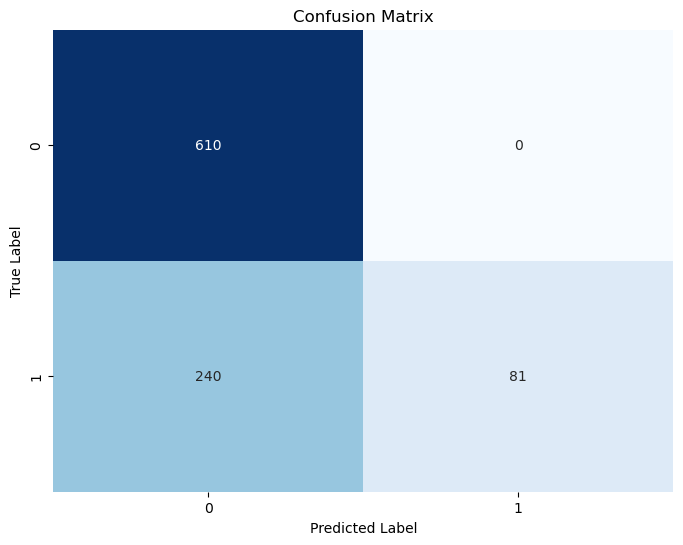

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Assume predictions_rounded and actual are already available
# actual = test_df_np[:, 0]  # Assuming the first column is the actual target

# Confusion Matrix
conf_matrix = confusion_matrix(actual, predictions_rounded)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [84]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, Rule, rule_configs


rules = [
    Rule.sagemaker(rule_configs.overtraining()),  # Detects when the model is overtraining (overfitting)
    Rule.sagemaker(rule_configs.loss_not_decreasing()),  # Detects when the loss stops decreasing
]

# Define Debugger Hook Configuration

debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/{prefix}/debugger-output',
    collection_configs=[
        CollectionConfig(name="metrics", parameters={"save_interval": "5"}),  # Capture metrics every 5 steps
    ]
)


xgboost_estimator_debug = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size=5,
    output_path=output_path,
    debugger_hook_config=debugger_hook_config,
    rules=rules  # Attach the rules
)

# Train the model
xgboost_estimator_debug.fit({'train': train_input, 'validation': validation_input})


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-03-09-55-59-739


2024-09-03 09:56:00 Starting - Starting the training job...
2024-09-03 09:56:27 Starting - Preparing the instances for trainingOvertraining: InProgress
LossNotDecreasing: InProgress
...
2024-09-03 09:56:58 Downloading - Downloading input data...
2024-09-03 09:57:20 Downloading - Downloading the training image.....[2024-09-03 09:58:17.020 ip-10-2-201-49.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-09-03 09:58:17.042 ip-10-2-201-49.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-09-03:09:58:17:INFO] Imported framework sagemaker_xgboost_container.training
[2024-09-03:09:58:17:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-09-03:09:58:17:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-03:09:58:17:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-09-03:09:58:17:INFO] Determined 0 GPU(s) available on the instance.
[2024-09-03:09:58:17:INFO] D

In [85]:
import time

# Monitor the training job and the rule evaluations
for _ in range(360):  # Adjust the range based on your expected training duration
    job_name = xgboost_estimator_debug.latest_training_job.name
    client = xgboost_estimator_debug.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    
    print(f"Training job status: {training_job_status}, Rule Evaluation Status: {rule_evaluation_status}")
    
    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break
    
    time.sleep(10)  # Poll every 10 seconds

# Print the final rule evaluation status
rule_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
for rule in rule_summary:
    print(f"Rule: {rule['RuleConfigurationName']}, Status: {rule['RuleEvaluationStatus']}")


Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProg

In [ ]:
!pip install smdebug

In [86]:
from smdebug.trials import create_trial

# Load the data from the S3 path where Debugger saved it
s3_output_path = xgboost_estimator_debug.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)


[2024-09-03 10:01:28.895 default:604 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ml-28573/debugger/debugger-output/sagemaker-xgboost-2024-09-03-09-55-59-739/debug-output


In [87]:
for tensor_name in trial.tensor_names():
    print(tensor_name)


train-rmse
validation-rmse


In [88]:
# Retrieve the train and validation RMSE tensors
train_rmse_tensor = trial.tensor('train-rmse')
validation_rmse_tensor = trial.tensor('validation-rmse')

# Get the steps (epochs) and values for each tensor
train_rmse_steps = train_rmse_tensor.steps()
train_rmse_values = np.array([train_rmse_tensor.value(step) for step in train_rmse_steps])

validation_rmse_steps = validation_rmse_tensor.steps()
validation_rmse_values = np.array([validation_rmse_tensor.value(step) for step in validation_rmse_steps])


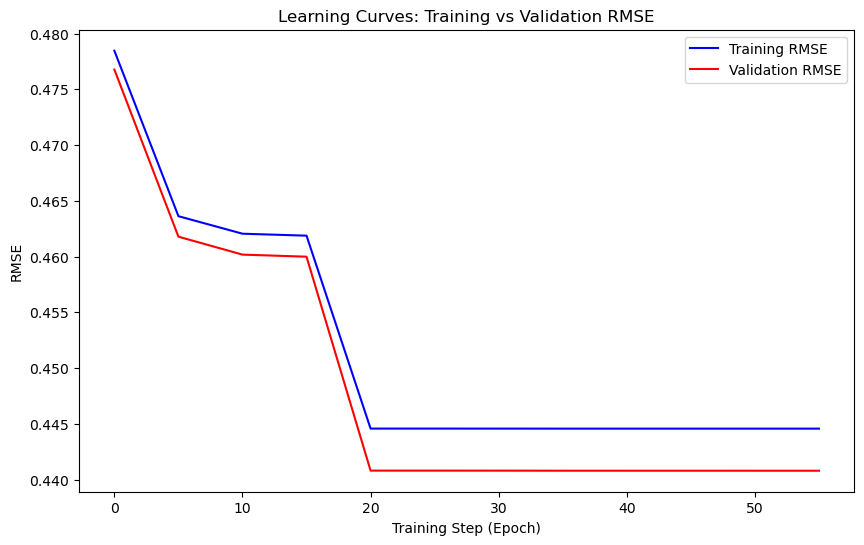

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training RMSE
plt.plot(train_rmse_steps, train_rmse_values, label='Training RMSE', color='blue')

# Plot validation RMSE
plt.plot(validation_rmse_steps, validation_rmse_values, label='Validation RMSE', color='red')

# Add labels and title
plt.xlabel('Training Step (Epoch)')
plt.ylabel('RMSE')
plt.title('Learning Curves: Training vs Validation RMSE')
plt.legend()

# Show the plot
plt.show()


In [90]:
# Print the contents to verify
print("Train RMSE Steps:", train_rmse_steps)
print("Train RMSE Values:", train_rmse_values)

print("Validation RMSE Steps:", validation_rmse_steps)
print("Validation RMSE Values:", validation_rmse_values)


Train RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Train RMSE Values: [[0.47846699]
 [0.46362741]
 [0.4620554 ]
 [0.4618795 ]
 [0.44457662]
 [0.44457671]
 [0.44457516]
 [0.44457311]
 [0.44457307]
 [0.44457307]
 [0.44457321]
 [0.44457324]]
Validation RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Validation RMSE Values: [[0.47677623]
 [0.46178845]
 [0.46018003]
 [0.45999307]
 [0.44080658]
 [0.44080672]
 [0.44080406]
 [0.44079902]
 [0.44079836]
 [0.44079861]
 [0.44079773]
 [0.44079768]]


In [91]:
# Initialize hyperparameters
hyperparameters = {
        "max_depth":"5", # lower depth
        "eta":"0.2",
        "gamma":"5", # change value here
        "min_child_weight":"6",
        "subsample":"0.5", # lower value
        "objective":"reg:squarederror",
        "num_round":"60"}

In [92]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, Rule, rule_configs


rules = [
    Rule.sagemaker(rule_configs.overtraining()),  # Detects when the model is overtraining (overfitting)
    Rule.sagemaker(rule_configs.loss_not_decreasing()),  # Detects when the loss stops decreasing
]

# Define Debugger Hook Configuration

debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/{prefix}/debugger-output',
    collection_configs=[
        CollectionConfig(name="metrics", parameters={"save_interval": "5"}),  # Capture metrics every 5 steps
    ]
)


xgboost_estimator_debug = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size=5,
    output_path=output_path,
    debugger_hook_config=debugger_hook_config,
    rules=rules  # Attach the rules
)

# Train the model
xgboost_estimator_debug.fit({'train': train_input, 'validation': validation_input})


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-03-10-01-32-452


2024-09-03 10:01:34 Starting - Starting the training job...
2024-09-03 10:01:58 Starting - Preparing the instances for trainingOvertraining: InProgress
LossNotDecreasing: InProgress
...
2024-09-03 10:02:20 Downloading - Downloading input data...
2024-09-03 10:02:58 Downloading - Downloading the training image...
2024-09-03 10:03:36 Training - Training image download completed. Training in progress...[2024-09-03 10:03:43.734 ip-10-0-135-246.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-09-03 10:03:43.759 ip-10-0-135-246.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-09-03:10:03:44:INFO] Imported framework sagemaker_xgboost_container.training
[2024-09-03:10:03:44:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-09-03:10:03:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-03:10:03:44:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-09-03:

In [93]:
import time

# Monitor the training job and the rule evaluations
for _ in range(360):  # Adjust the range based on your expected training duration
    job_name = xgboost_estimator_debug.latest_training_job.name
    client = xgboost_estimator_debug.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    
    print(f"Training job status: {training_job_status}, Rule Evaluation Status: {rule_evaluation_status}")
    
    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break
    
    time.sleep(10)  # Poll every 10 seconds

# Print the final rule evaluation status
rule_summary = xgboost_estimator_debug.latest_training_job.rule_job_summary()
for rule in rule_summary:
    print(f"Rule: {rule['RuleConfigurationName']}, Status: {rule['RuleEvaluationStatus']}")


Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: NoIssu

In [30]:
!pip install smdebug

In [94]:
from smdebug.trials import create_trial

# Load the data from the S3 path where Debugger saved it
s3_output_path = xgboost_estimator_debug.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)


[2024-09-03 10:06:41.053 default:604 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ml-28573/debugger/debugger-output/sagemaker-xgboost-2024-09-03-10-01-32-452/debug-output


In [95]:
for tensor_name in trial.tensor_names():
    print(tensor_name)


train-rmse
validation-rmse


In [96]:
# Retrieve the train and validation RMSE tensors
train_rmse_tensor = trial.tensor('train-rmse')
validation_rmse_tensor = trial.tensor('validation-rmse')

# Get the steps (epochs) and values for each tensor
train_rmse_steps = train_rmse_tensor.steps()
train_rmse_values = np.array([train_rmse_tensor.value(step) for step in train_rmse_steps])

validation_rmse_steps = validation_rmse_tensor.steps()
validation_rmse_values = np.array([validation_rmse_tensor.value(step) for step in validation_rmse_steps])


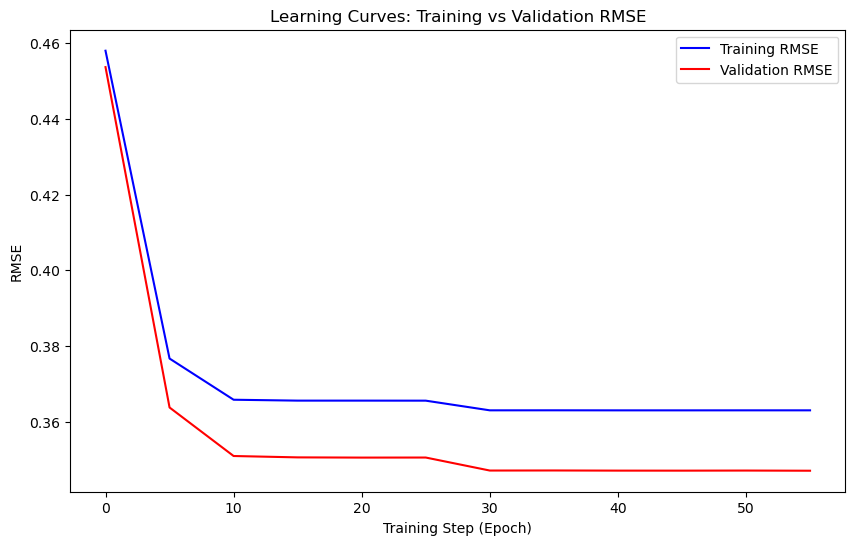

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training RMSE
plt.plot(train_rmse_steps, train_rmse_values, label='Training RMSE', color='blue')

# Plot validation RMSE
plt.plot(validation_rmse_steps, validation_rmse_values, label='Validation RMSE', color='red')

# Add labels and title
plt.xlabel('Training Step (Epoch)')
plt.ylabel('RMSE')
plt.title('Learning Curves: Training vs Validation RMSE')
plt.legend()

# Show the plot
plt.show()


In [98]:
# Print the contents to verify
print("Train RMSE Steps:", train_rmse_steps)
print("Train RMSE Values:", train_rmse_values)

print("Validation RMSE Steps:", validation_rmse_steps)
print("Validation RMSE Values:", validation_rmse_values)


Train RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Train RMSE Values: [[0.45803475]
 [0.37670372]
 [0.36582111]
 [0.36558543]
 [0.3655869 ]
 [0.36557636]
 [0.36302102]
 [0.36302919]
 [0.36301551]
 [0.36301454]
 [0.36302018]
 [0.36302051]]
Validation RMSE Steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
Validation RMSE Values: [[0.4537078 ]
 [0.36377222]
 [0.35095253]
 [0.35059081]
 [0.35053421]
 [0.35054948]
 [0.34711191]
 [0.34713209]
 [0.34709224]
 [0.34708502]
 [0.3471095 ]
 [0.34706539]]


In [110]:
# Deploy model

predictor_improved = xgboost_estimator_debug.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-09-03-10-58-01-078
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-09-03-10-58-01-078
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-09-03-10-58-01-078


-------!

In [111]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set up the predictor
predictor_improved.content_type = "text/csv"
predictor_improved.serializer = sagemaker.serializers.CSVSerializer()
predictor_improved.deserializer = sagemaker.deserializers.JSONDeserializer()


In [112]:
# Define a function to make predictions
def predict(data, predictor_improved, rows=500):
    # Split the test data into mini-batches of rows
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    
    # Initialize an empty list for predictions
    predictions = []
    
    # Iterate through the mini-batches and make predictions
    for array in split_array:
        # Make a prediction for the mini-batch
        pred = predictor_improved.predict(array)
        
        # Assuming pred is a dictionary, extract the prediction values
        if isinstance(pred, dict):
            pred_values = pred.get("predictions", [])
            
            # If predictions are a list of dictionaries, extract the values
            if isinstance(pred_values, list):
                for value in pred_values:
                    if isinstance(value, dict):
                        # Assuming each dictionary has a key that holds the actual prediction
                        predictions.append(value.get("predicted_label", value.get("score", 0.0)))
                    else:
                        predictions.append(value)
        else:
            predictions.append(pred)

    # Convert the list of predictions directly to a NumPy array
    return np.array(predictions, dtype=float)

# Load your test data into a NumPy array (assuming your test data is a Pandas DataFrame)
test_df_np = test_df.to_numpy()

# Separate the target variable (assumed to be in the first column) from the features
actual = test_df_np[:, 0]   # First column is the target
features = test_df_np[:, 1:]  # Remaining columns are the features

# Make predictions on the features only
predictions = predict(features, predictor_improved)

# Since this is binary classification, round the predictions
predictions_rounded = np.round(predictions)

Confusion Matrix:
 [[603   7]
 [147 174]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89       610
           1       0.96      0.54      0.69       321

    accuracy                           0.83       931
   macro avg       0.88      0.77      0.79       931
weighted avg       0.86      0.83      0.82       931


Accuracy Score: 0.8345864661654135


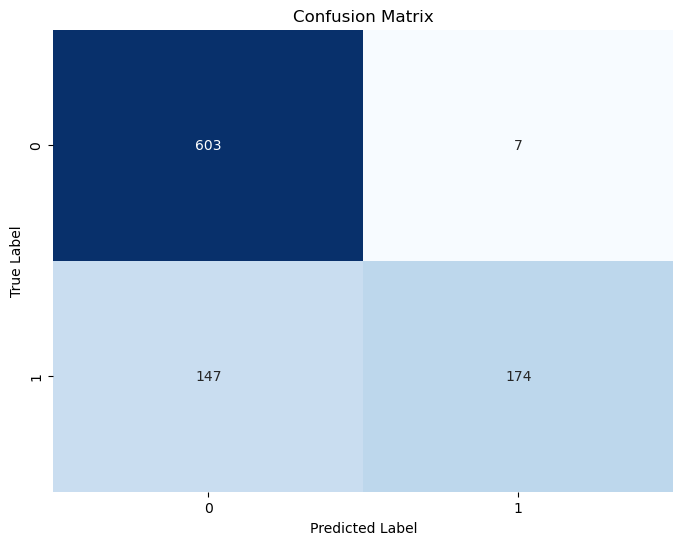

In [113]:
# Evaluate the model
conf_matrix = confusion_matrix(actual, predictions_rounded)
class_report = classification_report(actual, predictions_rounded)
accuracy = accuracy_score(actual, predictions_rounded)

# Print the evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy Score:", accuracy)# Confusion Matrix
conf_matrix = confusion_matrix(actual, predictions_rounded)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
